
========== Running Ablations for R1_True ==========

--- R1_True: Set A - Learning Rate Comparison ---
Finished: R1_True_LR-High_BT-ema_Ns1_GC-10.0. Final mu=5.006, sigma=0.072
Finished: R1_True_LR-Medium_BT-ema_Ns1_GC-10.0. Final mu=4.990, sigma=0.234
Finished: R1_True_LR-Low_BT-ema_Ns1_GC-10.0. Final mu=2.307, sigma=1.199
Saved plot to plots/R1_True-Learning-Rate-Comparison.png


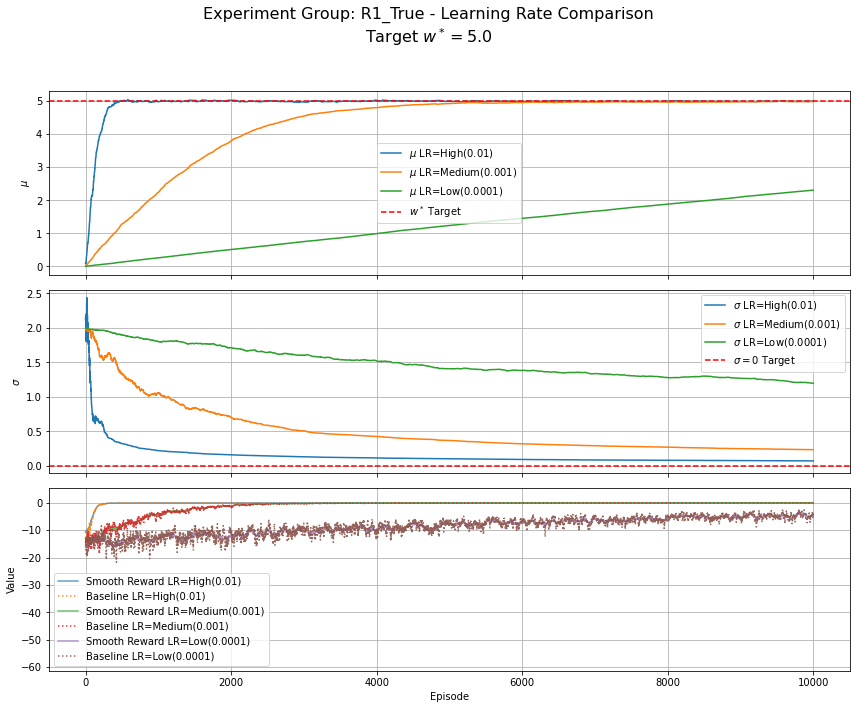


--- R1_True: Set B - Baseline Comparison ---
Finished: R1_True_LR-Medium_BT-none_Ns1_GC-10.0. Final mu=5.003, sigma=0.314
Saved plot to plots/R1_True-Baseline-Comparison.png


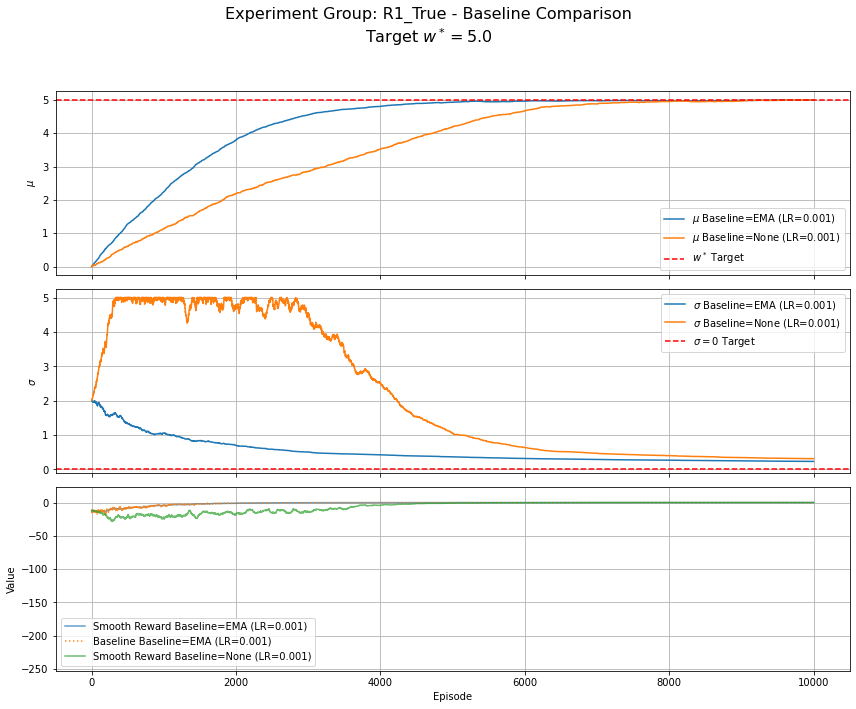


--- R1_True: Set C - Diminishing Stepsize Comparison ---
Finished: R1_True_LR-Diminish_BT-ema_Ns1_GC-10.0. Final mu=5.009, sigma=0.119
Saved plot to plots/R1_True-Stepsize-Schedule-Comparison.png


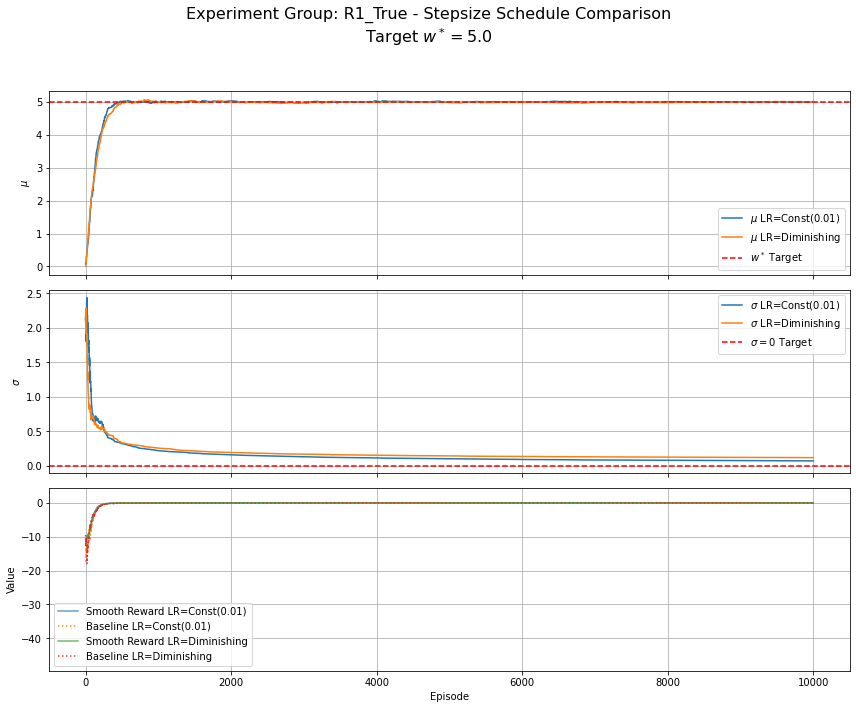


--- R1_True: Set D - Batch Gradient Estimator Comparison ---
Finished: R1_True_LR-Medium_BT-ema_Ns10_GC-10.0. Final mu=5.001, sigma=0.224
Saved plot to plots/R1_True-Batch-Gradient-Estimator-Comparison.png


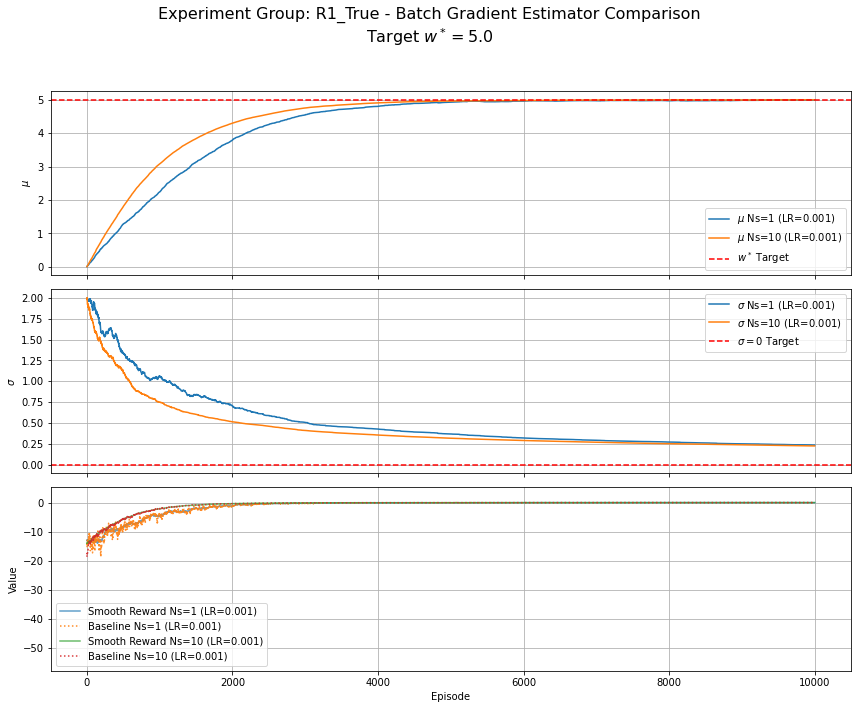


========== Running Ablations for R2_Randomized ==========

--- R2_Randomized: Set A - Learning Rate Comparison ---
Finished: R2_Randomized_LR-High_BT-ema_Ns1_GC-10.0. Final mu=4.492, sigma=0.207
Finished: R2_Randomized_LR-Medium_BT-ema_Ns1_GC-10.0. Final mu=5.058, sigma=0.356
Finished: R2_Randomized_LR-Low_BT-ema_Ns1_GC-10.0. Final mu=2.235, sigma=1.202
Saved plot to plots/R2_Randomized-Learning-Rate-Comparison.png


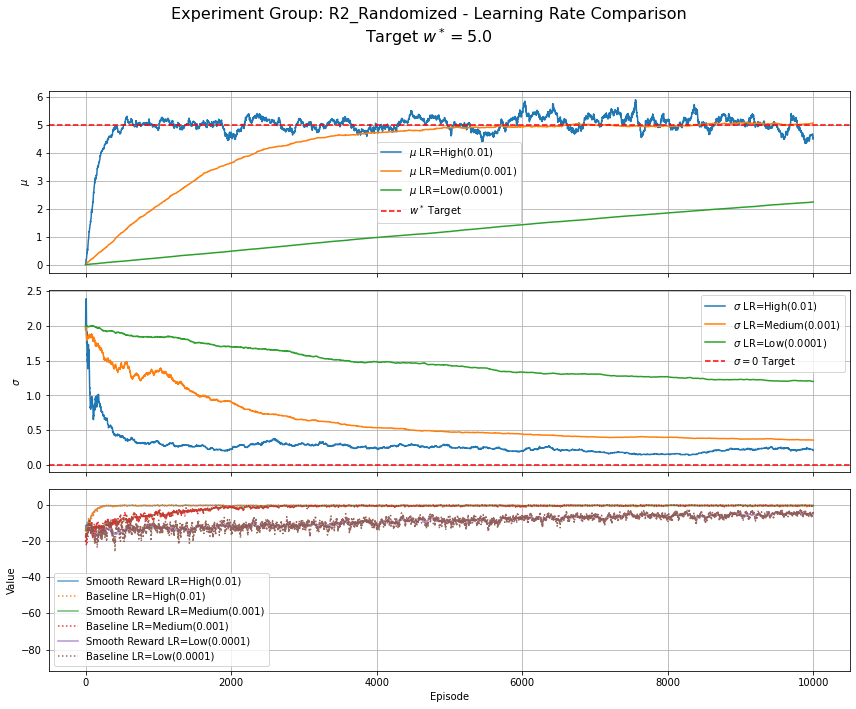


--- R2_Randomized: Set B - Baseline Comparison ---
Finished: R2_Randomized_LR-Medium_BT-none_Ns1_GC-10.0. Final mu=4.941, sigma=0.421
Saved plot to plots/R2_Randomized-Baseline-Comparison.png


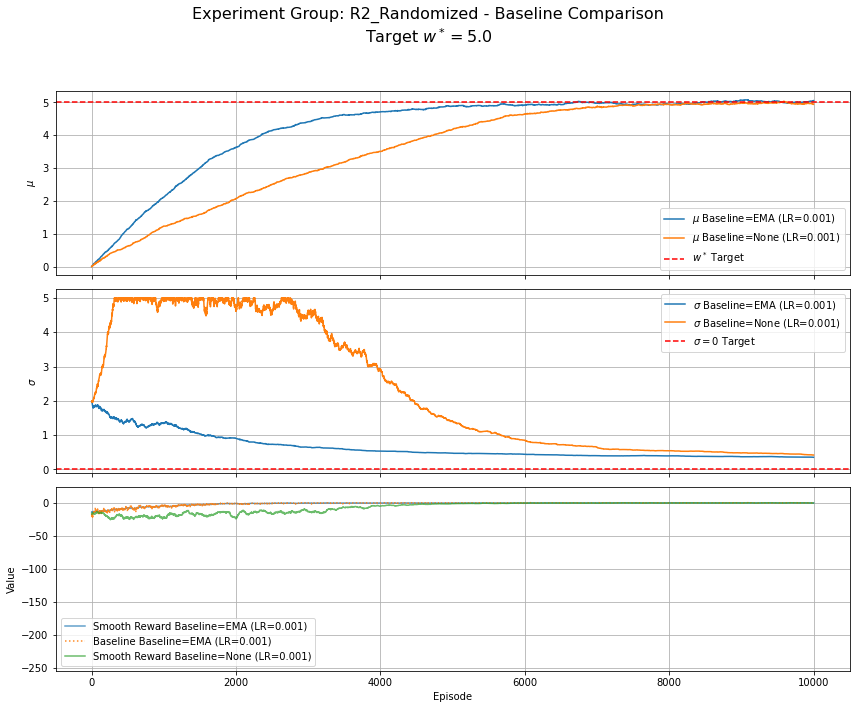


--- R2_Randomized: Set C - Diminishing Stepsize Comparison ---
Finished: R2_Randomized_LR-Diminish_BT-ema_Ns1_GC-10.0. Final mu=4.942, sigma=0.218
Saved plot to plots/R2_Randomized-Stepsize-Schedule-Comparison.png


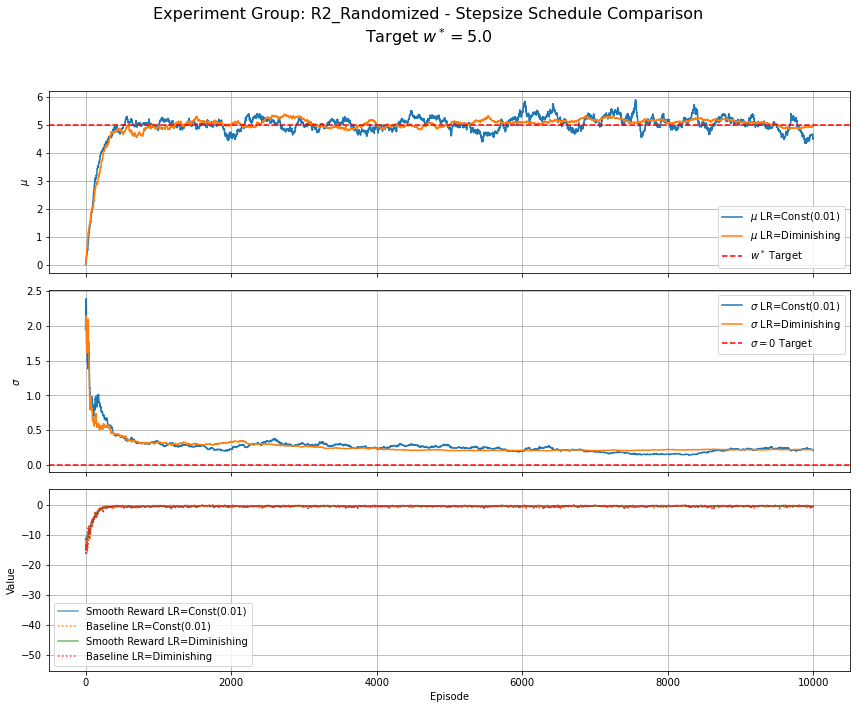


--- R2_Randomized: Set D - Batch Gradient Estimator Comparison ---
Finished: R2_Randomized_LR-Medium_BT-ema_Ns10_GC-10.0. Final mu=5.011, sigma=0.225
Saved plot to plots/R2_Randomized-Batch-Gradient-Estimator-Comparison.png


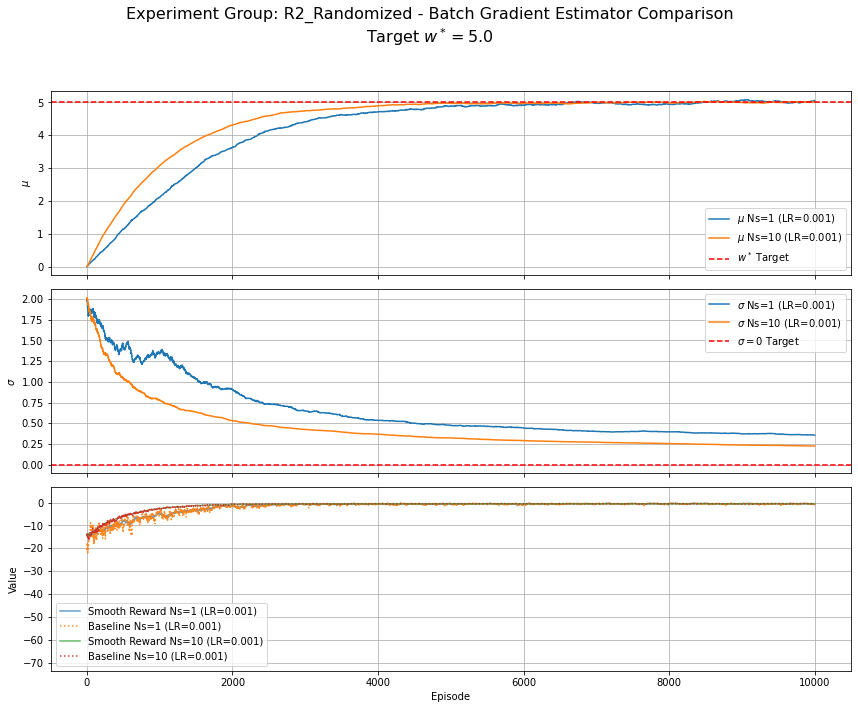


========== Running Proxy Batch Size Comparison for R3_Proxy ==========
Finished: R3_Proxy_LR-High_BT-ema_Ns1_ProxyNs1_GC-10.0. Final mu=5.265, sigma=0.071
Finished: R3_Proxy_LR-High_BT-ema_Ns1_ProxyNs5_GC-10.0. Final mu=4.740, sigma=0.070
Finished: R3_Proxy_LR-High_BT-ema_Ns1_ProxyNs10_GC-10.0. Final mu=5.133, sigma=0.073
Finished: R3_Proxy_LR-High_BT-ema_Ns1_ProxyNs20_GC-10.0. Final mu=5.225, sigma=0.070
Saved plot to plots/R3_Proxy-Proxy-Batch-Size-Comparison.png


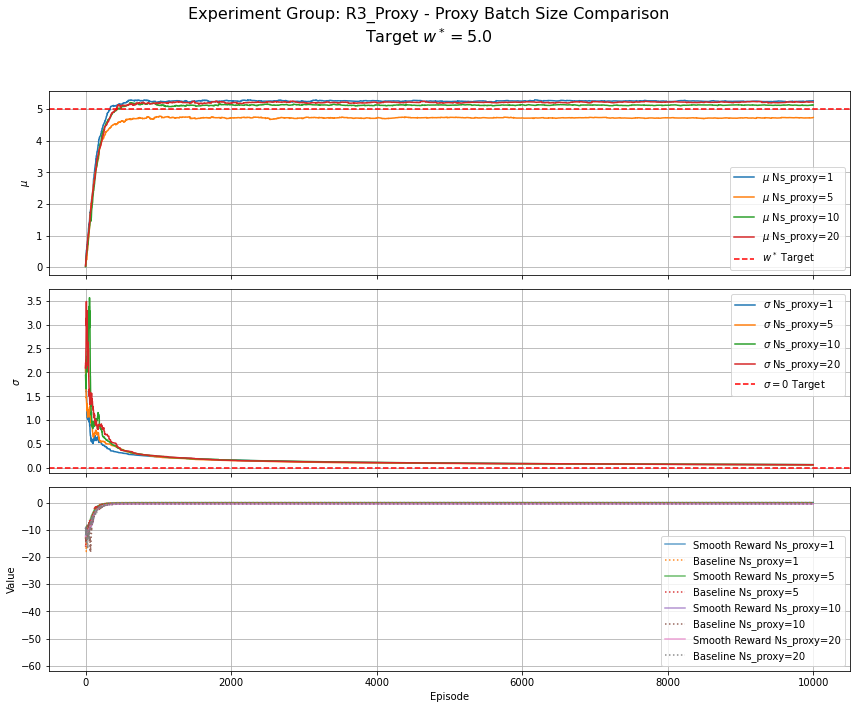


========== Running Single Configuration for R4_DiscreteSparse ==========
Finished: R4_DiscreteSparse_LR-High_BT-ema_Ns1_GC-10.0. Final mu=4.997, sigma=0.119
Saved plot to plots/R4_DiscreteSparse-Single-Run.png


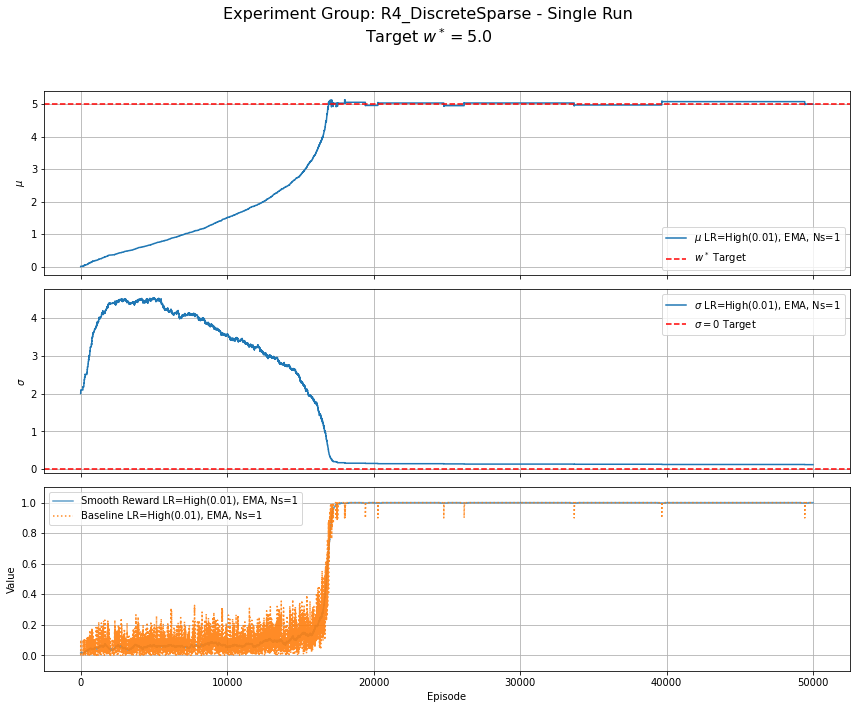


========== Running Single Configuration for R5_SparseContinuous ==========
Finished: R5_SparseContinuous_LR-VSparse_BT-ema_Ns1_GC-10.0. Final mu=5.004, sigma=0.050
Saved plot to plots/R5_SparseContinuous-Single-Run.png


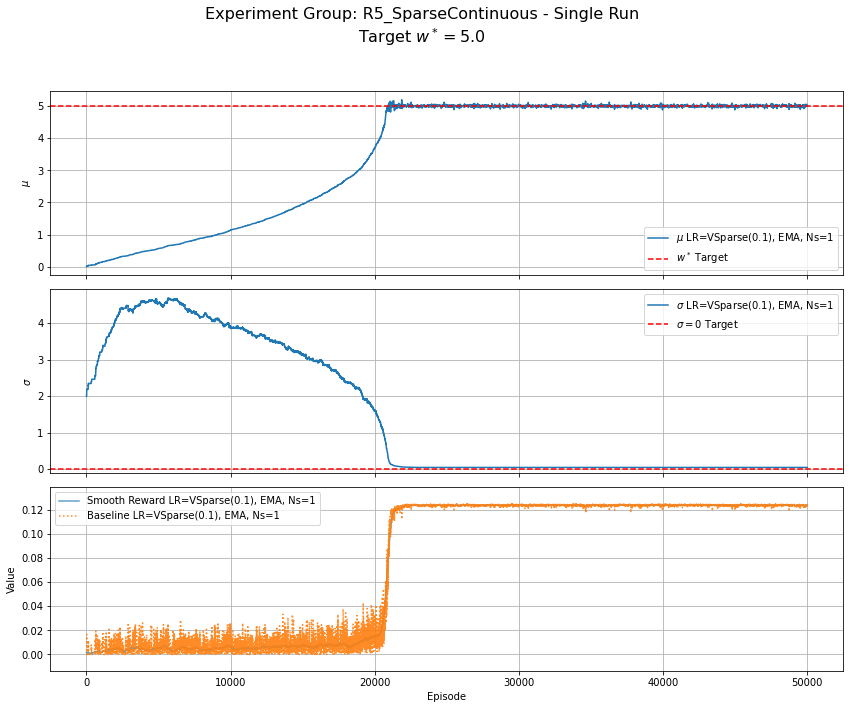


--- All experiments complete. ---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os 
import re 

# --- I. Core System Components ---

class REINFORCEAgent:
    def __init__(self, initial_mu, initial_psi, learning_rate_schedule, 
                 baseline_type="ema", ema_alpha=0.1, 
                 psi_min_max=(-np.log(1/0.05), np.log(5.0)), # sigma in [0.05, 5.0]
                 grad_clip_norm=10.0): 
        self.mu = initial_mu
        self.psi = initial_psi 
        
        if callable(learning_rate_schedule):
            self.lr_schedule = learning_rate_schedule
        else: 
            self.lr_schedule = lambda k: learning_rate_schedule 
            
        self.baseline_type = baseline_type
        self.ema_alpha = ema_alpha
        self.psi_min, self.psi_max = psi_min_max 
        self.grad_clip_norm = grad_clip_norm # Default is 10.0, as per plan
        
        self.baseline_value = 0.0 
        self.current_step = 0 

    @property
    def sigma(self):
        clipped_psi = np.clip(self.psi, self.psi_min, self.psi_max)
        return np.exp(clipped_psi)

    def get_action(self):
        return np.random.normal(self.mu, self.sigma)

    def update_with_averaged_gradients(self, avg_grad_J_mu_component, avg_grad_J_psi_component):
        """Applies updates using pre-averaged gradient components (E[score * advantage])."""
        current_lr = self.lr_schedule(self.current_step)
        
        update_mu_component = avg_grad_J_mu_component
        update_psi_component = avg_grad_J_psi_component

        # Gradient Clipping applied to the policy gradient components E[score * advantage]
        norm = np.sqrt(update_mu_component**2 + update_psi_component**2)
        # Use default grad_clip_norm unless explicitly set to None
        apply_clip = self.grad_clip_norm is not None 
        if apply_clip and norm > self.grad_clip_norm and norm > 0:
            clip_factor = self.grad_clip_norm / norm
            update_mu_component *= clip_factor
            update_psi_component *= clip_factor
            
        # Apply learning rate
        self.mu += current_lr * update_mu_component
        self.psi += current_lr * update_psi_component

        # Clip psi state variable after update
        self.psi = np.clip(self.psi, self.psi_min, self.psi_max)
        self.current_step += 1

# --- II. Reward Functions & Global Params ---
TRUE_W_STAR = 5.0
NOISE_SIGMA_Z_R2 = 1.0 
SPARSE_REWARD_THRESHOLD_R4R5 = -0.125 

def reward_R1_true(w, w_star=TRUE_W_STAR):
    return -0.5 * (w - w_star)**2

def reward_R2_randomized(w, w_star=TRUE_W_STAR, sigma_z=NOISE_SIGMA_Z_R2):
    z = np.random.normal(0, sigma_z)
    return -0.5 * (w - (w_star + z))**2 

def reward_R3_proxy(w, w_star=TRUE_W_STAR, s_train_noise_values=[]): 
    if not isinstance(s_train_noise_values, np.ndarray) and not s_train_noise_values: 
         print("Warning: reward_R3_proxy called with empty s_train_noise_values")
         return 0.0 
    batch_neg_losses = [-0.5 * (w - (w_star + z_i))**2 for z_i in s_train_noise_values]
    return np.mean(batch_neg_losses) 

def reward_R4_discrete_sparse(w, w_star=TRUE_W_STAR, tol_reward=SPARSE_REWARD_THRESHOLD_R4R5):
    true_neg_loss_val = -0.5 * (w - w_star)**2
    return 1.0 if true_neg_loss_val > tol_reward else 0.0

def reward_R5_sparse_continuous_shifted(w, w_star=TRUE_W_STAR, tol_reward=SPARSE_REWARD_THRESHOLD_R4R5):
    true_neg_loss_val = -0.5 * (w - w_star)**2
    if true_neg_loss_val > tol_reward:
        return true_neg_loss_val - tol_reward 
    else:
        return 0.0 

REWARD_FUNCTIONS = {
    "R1_True": {"fn": reward_R1_true, "kwargs": {"w_star": TRUE_W_STAR}, "plot_w_star": TRUE_W_STAR},
    "R2_Randomized": {"fn": reward_R2_randomized, "kwargs": {"w_star": TRUE_W_STAR, "sigma_z": NOISE_SIGMA_Z_R2}, "plot_w_star": TRUE_W_STAR},
    "R3_Proxy": {"fn": reward_R3_proxy, "kwargs": {"w_star": TRUE_W_STAR}, "plot_w_star": TRUE_W_STAR}, # Default kwargs empty for s_train_noise
    "R4_DiscreteSparse": {"fn": reward_R4_discrete_sparse, "kwargs": {"w_star": TRUE_W_STAR, "tol_reward": SPARSE_REWARD_THRESHOLD_R4R5}, "plot_w_star": TRUE_W_STAR},
    "R5_SparseContinuous": {"fn": reward_R5_sparse_continuous_shifted, "kwargs": {"w_star": TRUE_W_STAR, "tol_reward": SPARSE_REWARD_THRESHOLD_R4R5}, "plot_w_star": TRUE_W_STAR}, 
}

# --- III. Experiment Runner ---
def run_experiment(exp_id, agent_config_dict, reward_fn_key, reward_kwargs_override,
                   num_episodes, initial_mu, initial_psi, Ns_grad_batch_size=1):
    
    agent = REINFORCEAgent(initial_mu, initial_psi, **agent_config_dict)
    
    reward_entry = REWARD_FUNCTIONS[reward_fn_key]
    reward_fn = reward_entry["fn"]
    reward_fn_kwargs = reward_kwargs_override if reward_kwargs_override is not None else reward_entry["kwargs"]

    history = {
        'exp_id': exp_id,
        'agent_config': agent_config_dict, 
        'mu': np.zeros(num_episodes),
        'sigma': np.zeros(num_episodes),
        'reward_raw_avg': np.zeros(num_episodes),
        'baseline_val': np.zeros(num_episodes),
        'w_sampled_first': np.zeros(num_episodes),
    }

    if agent.baseline_type == "ema" and agent.baseline_value == 0.0:
        num_init_samples = max(10, Ns_grad_batch_size) 
        init_rewards = []
        for _ in range(num_init_samples):
             est_w = agent.get_action()
             est_r = reward_fn(est_w, **reward_fn_kwargs)
             if np.isfinite(est_r): init_rewards.append(est_r)
        if init_rewards: agent.baseline_value = np.mean(init_rewards)

    for episode in range(num_episodes):
        batch_grad_J_mu_components = [] 
        batch_grad_J_psi_components = [] 
        
        w_first_in_batch = agent.get_action()
        history['w_sampled_first'][episode] = w_first_in_batch
        
        current_batch_baseline = agent.baseline_value if agent.baseline_type == "ema" else 0.0
        history['baseline_val'][episode] = current_batch_baseline

        episode_rewards_for_ema_update = []

        for i_sample in range(Ns_grad_batch_size):
            w_sampled = w_first_in_batch if i_sample == 0 else agent.get_action()
                 
            current_reward = reward_fn(w_sampled, **reward_fn_kwargs)
            if not np.isfinite(current_reward): current_reward = 0.0 
            episode_rewards_for_ema_update.append(current_reward)

            advantage = current_reward - current_batch_baseline 
            
            sigma_sq = agent.sigma**2 
            sigma_sq_stable = sigma_sq + 1e-9 
            
            grad_mu_log_pi = (w_sampled - agent.mu) / sigma_sq_stable
            grad_psi_log_pi = ((w_sampled - agent.mu)**2 / sigma_sq_stable) - 1 
            
            if not np.isfinite(grad_mu_log_pi): grad_mu_log_pi = 0.0
            if not np.isfinite(grad_psi_log_pi): grad_psi_log_pi = 0.0
            
            batch_grad_J_mu_components.append(grad_mu_log_pi * advantage)
            batch_grad_J_psi_components.append(grad_psi_log_pi * advantage)

        avg_grad_J_mu_component = np.mean(batch_grad_J_mu_components)
        avg_grad_J_psi_component = np.mean(batch_grad_J_psi_components)
        
        if not np.isfinite(avg_grad_J_mu_component): avg_grad_J_mu_component = 0.0
        if not np.isfinite(avg_grad_J_psi_component): avg_grad_J_psi_component = 0.0
        
        agent.update_with_averaged_gradients(avg_grad_J_mu_component, avg_grad_J_psi_component)
        
        avg_episode_reward = np.mean(episode_rewards_for_ema_update)
        if agent.baseline_type == "ema":
            update_val = avg_episode_reward if np.isfinite(avg_episode_reward) else 0.0
            agent.baseline_value = (1 - agent.ema_alpha) * agent.baseline_value + agent.ema_alpha * update_val
            
        history['mu'][episode] = agent.mu
        history['sigma'][episode] = agent.sigma 
        history['reward_raw_avg'][episode] = avg_episode_reward
        
    print(f"Finished: {exp_id}. Final mu={agent.mu:.3f}, sigma={agent.sigma:.3f}")
    return history

# --- IV. Plotting Utilities ---
def plot_experiment_history(histories_data_list, experiment_group_title, plot_target_w_star, save_dir="plots"):
    if not isinstance(histories_data_list, list) or not histories_data_list:
        print("Warning: histories_data_list should be a non-empty list of (history_dict, legend_suffix) tuples.")
        return

    if not os.path.exists(save_dir): os.makedirs(save_dir)
    clean_title = re.sub(r'[^\w\s-]', '', experiment_group_title).strip()
    clean_title = re.sub(r'[-\s]+', '-', clean_title)
    filename = os.path.join(save_dir, f"{clean_title}.png")

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Experiment Group: {experiment_group_title}\nTarget $w^*={plot_target_w_star}$", fontsize=16)

    all_mus, all_sigmas, all_rewards, all_baselines = [], [], [], []
    for history_dict, _ in histories_data_list:
        all_mus.append(history_dict['mu'])
        all_sigmas.append(history_dict['sigma'])
        all_rewards.append(history_dict['reward_raw_avg'])
        agent_bsl_type = history_dict.get('agent_config', {}).get('baseline_type', 'none')
        all_baselines.append(history_dict['baseline_val'] if agent_bsl_type == 'ema' else None)

    num_episodes = len(histories_data_list[0][0]['mu']) 
    
    for i in range(len(histories_data_list)):
        _, legend_suffix = histories_data_list[i]
        axs[0].plot(all_mus[i], label=f'$\mu$ {legend_suffix}')
        axs[1].plot(all_sigmas[i], label=f'$\sigma$ {legend_suffix}')

        reward_data = all_rewards[i]
        window_size = min(max(1, num_episodes // 100), 1000) 
        if num_episodes >= window_size :
            smooth_rewards_pd = pd.Series(reward_data).rolling(window_size, center=True, min_periods=1).mean()
            axs[2].plot(smooth_rewards_pd, label=f'Smooth Reward {legend_suffix}', alpha=0.7)
        else: 
            axs[2].plot(reward_data, label=f'Raw Reward {legend_suffix}', alpha=0.5, linestyle=':')
        if all_baselines[i] is not None:
             axs[2].plot(all_baselines[i], label=f'Baseline {legend_suffix}', linestyle=':', alpha=0.9)

    axs[0].axhline(plot_target_w_star, color='r', linestyle='--', label='$w^*$ Target')
    axs[0].set_ylabel('$\mu$'); axs[0].legend(loc='best'); axs[0].grid(True)
    axs[1].set_ylabel('$\sigma$'); axs[1].axhline(0, color='r', linestyle='--', label='$\sigma=0$ Target')
    axs[1].legend(loc='best'); axs[1].grid(True); axs[1].set_ylim(bottom=-0.1) 
    axs[2].set_xlabel('Episode'); axs[2].set_ylabel('Value')
    axs[2].legend(loc='best'); axs[2].grid(True)
    
    combined_vals = np.concatenate([x for x in all_rewards + all_baselines if x is not None and len(x)>0])
    if len(combined_vals) > 0 and np.all(np.isfinite(combined_vals)):
        min_val, max_val = np.min(combined_vals), np.max(combined_vals)
        padding = (max_val - min_val) * 0.1 + 1e-3 
        axs[2].set_ylim(min_val - padding, max_val + padding)
    else: axs[2].set_ylim(-0.1, 0.1) 

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.savefig(filename) 
    print(f"Saved plot to {filename}"); plt.show()
    
# --- V. Global Parameters & Experiment Definitions ---

INITIAL_MU = 0.0
INITIAL_PSI = np.log(2.0) 
NUM_EPISODES_STD = int(1e4) 
NUM_EPISODES_SPARSE = int(5e4) 
EMA_ALPHA = 0.1
PSI_MIN_MAX = (np.log(0.05), np.log(5.0)) 
DEFAULT_GRAD_CLIP_NORM = 10.0 # Always ON

# LRs for R1, R2 (STD rewards)
LRS_SET_A_STD = {"High": 0.01, "Medium": 0.001, "Low": 0.0001} 
BASE_LR_MED_STD = LRS_SET_A_STD["Medium"]
CHOSEN_LR_STD_HIGH = LRS_SET_A_STD["High"] 

# LR for R3 (Proxy), R4 (Discrete Sparse)
CHOSEN_LR_R3R4 = LRS_SET_A_STD["High"] # Use High=0.01

# LR for R5 (Sparse Continuous)
CHOSEN_LR_R5 = 0.1 # Use VSparse=0.1

# Diminishing LR (for R1, R2 only)
K_DECAY_DIMINISH_SET_C = NUM_EPISODES_STD / 5 
ALPHA_START_DIMINISH_SET_C = LRS_SET_A_STD["High"] # Match initial LR with High const LR

def diminishing_lr_schedule_set_c(k):
    return ALPHA_START_DIMINISH_SET_C / (1 + k / K_DECAY_DIMINISH_SET_C)

def get_exp_id(r_key, lr_desc, baseline_type, Ns_val, Ns_proxy=0):
    clip_str = str(DEFAULT_GRAD_CLIP_NORM) 
    proxy_str = f"_ProxyNs{Ns_proxy}" if Ns_proxy > 0 else ""
    return f"{r_key}_LR-{lr_desc}_BT-{baseline_type}_Ns{Ns_val}{proxy_str}_GC-{clip_str}"

# --- Main execution block ---
if __name__ == '__main__':
    all_run_histories = {} 

    # --- Run Ablations for R1 & R2 ---
    for r_key in ["R1_True", "R2_Randomized"]:
        print(f"\n{'='*10} Running Ablations for {r_key} {'='*10}")
        current_num_episodes = NUM_EPISODES_STD
        plot_w_star = REWARD_FUNCTIONS[r_key]["plot_w_star"]
        lrs_to_use = LRS_SET_A_STD
        medium_lr_label = "Medium"
        medium_lr_val = BASE_LR_MED_STD
        high_lr_val = LRS_SET_A_STD["High"]

        # Set A: Learning Rate Comparison (EMA, Ns=1, Clip=10)
        print(f"\n--- {r_key}: Set A - Learning Rate Comparison ---")
        histories_to_plot_A = []
        for lr_label, lr_val in lrs_to_use.items():
            exp_id = get_exp_id(r_key, lr_label, "ema", 1)
            agent_config = {"learning_rate_schedule": lr_val, "baseline_type": "ema", 
                            "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
            history = run_experiment(exp_id, agent_config, r_key, None, current_num_episodes, INITIAL_MU, INITIAL_PSI)
            all_run_histories[exp_id] = history
            histories_to_plot_A.append((history, f"LR={lr_label}({lr_val})"))
        plot_experiment_history(histories_to_plot_A, f"{r_key} - Learning Rate Comparison", plot_w_star)

        # Set B: Baseline Comparison (Medium LR, Ns=1, Clip=10)
        print(f"\n--- {r_key}: Set B - Baseline Comparison ---")
        histories_to_plot_B = []
        ema_run_id = get_exp_id(r_key, medium_lr_label, "ema", 1)
        if ema_run_id in all_run_histories:
             histories_to_plot_B.append((all_run_histories[ema_run_id], f"Baseline=EMA (LR={medium_lr_val})"))
        else: print(f"Error: EMA run {ema_run_id} not found for Set B reuse.")
        
        no_baseline_run_id = get_exp_id(r_key, medium_lr_label, "none", 1)
        agent_config_B2 = {"learning_rate_schedule": medium_lr_val, "baseline_type": "none",
                           "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
        history_B2 = run_experiment(no_baseline_run_id, agent_config_B2, r_key, None, current_num_episodes, INITIAL_MU, INITIAL_PSI)
        all_run_histories[no_baseline_run_id] = history_B2
        histories_to_plot_B.append((history_B2, f"Baseline=None (LR={medium_lr_val})"))
        plot_experiment_history(histories_to_plot_B, f"{r_key} - Baseline Comparison", plot_w_star)

        # Set C: Diminishing Stepsize Comparison (EMA, Ns=1, Clip=10)
        print(f"\n--- {r_key}: Set C - Diminishing Stepsize Comparison ---")
        histories_to_plot_C = []
        const_lr_run_id_C = get_exp_id(r_key, "High", "ema", 1) 
        if const_lr_run_id_C in all_run_histories:
             histories_to_plot_C.append((all_run_histories[const_lr_run_id_C], f"LR=Const({high_lr_val})"))
        else: print(f"Error: Const LR run {const_lr_run_id_C} not found for Set C reuse.")

        dim_lr_run_id_C = get_exp_id(r_key, "Diminish", "ema", 1)
        agent_config_C2 = {"learning_rate_schedule": diminishing_lr_schedule_set_c, "baseline_type": "ema",
                           "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
        history_C2 = run_experiment(dim_lr_run_id_C, agent_config_C2, r_key, None, current_num_episodes, INITIAL_MU, INITIAL_PSI)
        all_run_histories[dim_lr_run_id_C] = history_C2
        histories_to_plot_C.append((history_C2, "LR=Diminishing"))
        plot_experiment_history(histories_to_plot_C, f"{r_key} - Stepsize Schedule Comparison", plot_w_star)

        # Set D: Batch Gradient Estimator Comparison (Medium LR, EMA, Clip=10)
        print(f"\n--- {r_key}: Set D - Batch Gradient Estimator Comparison ---")
        histories_to_plot_D = []
        ns1_run_id_D = get_exp_id(r_key, medium_lr_label, "ema", 1) 
        if ns1_run_id_D in all_run_histories:
             histories_to_plot_D.append((all_run_histories[ns1_run_id_D], f"Ns=1 (LR={medium_lr_val})"))
        else: print(f"Error: Ns=1 run {ns1_run_id_D} not found for Set D reuse.")

        ns10_run_id_D = get_exp_id(r_key, medium_lr_label, "ema", 10)
        agent_config_D2 = {"learning_rate_schedule": medium_lr_val, "baseline_type": "ema",
                           "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
        history_D2 = run_experiment(ns10_run_id_D, agent_config_D2, r_key, None, current_num_episodes, INITIAL_MU, INITIAL_PSI, Ns_grad_batch_size=10)
        all_run_histories[ns10_run_id_D] = history_D2
        histories_to_plot_D.append((history_D2, f"Ns=10 (LR={medium_lr_val})"))
        plot_experiment_history(histories_to_plot_D, f"{r_key} - Batch Gradient Estimator Comparison", plot_w_star)

    # --- Run R3 Proxy Comparison ---
    r_key_r3 = "R3_Proxy" # Changed key name
    print(f"\n{'='*10} Running Proxy Batch Size Comparison for {r_key_r3} {'='*10}")
    current_num_episodes_r3 = NUM_EPISODES_STD
    plot_w_star_r3 = REWARD_FUNCTIONS[r_key_r3]["plot_w_star"]
    
    histories_to_plot_R3 = []
    proxy_batch_sizes = [1, 5, 10, 20]
    lr_val_r3 = CHOSEN_LR_STD_HIGH # Use High LR for all R3 runs
    lr_label_r3 = "High"

    # Regenerate S_TRAIN noise samples for different sizes
    np.random.seed(43) # Use different seed for R3 specific noise batches
    s_train_noises_r3_map = {
        N: np.random.normal(0, NOISE_SIGMA_Z_R2, N) for N in proxy_batch_sizes
    }

    for ns_proxy in proxy_batch_sizes:
        exp_id = get_exp_id(r_key_r3, lr_label_r3, "ema", 1, Ns_proxy=ns_proxy) # Ns_grad_batch_size is 1
        agent_config = {"learning_rate_schedule": lr_val_r3, "baseline_type": "ema", 
                        "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
        
        # Define the specific reward kwargs for this run
        current_reward_kwargs = {"w_star": TRUE_W_STAR, "s_train_noise_values": s_train_noises_r3_map[ns_proxy]}

        history = run_experiment(exp_id, agent_config, r_key_r3, current_reward_kwargs, # Pass override kwargs
                                 current_num_episodes_r3, INITIAL_MU, INITIAL_PSI, Ns_grad_batch_size=1) 
        
        all_run_histories[exp_id] = history
        histories_to_plot_R3.append((history, f"Ns_proxy={ns_proxy}"))
        
    plot_experiment_history(histories_to_plot_R3, f"{r_key_r3} - Proxy Batch Size Comparison", plot_w_star_r3)


    # --- Run Single Config for R4, R5 ---
    single_run_configs = {
        "R4_DiscreteSparse": {"lr": CHOSEN_LR_R3R4, "lr_label": "High", "num_eps": NUM_EPISODES_SPARSE}, 
        "R5_SparseContinuous": {"lr": CHOSEN_LR_R5, "lr_label": "VSparse", "num_eps": NUM_EPISODES_SPARSE}, 
    }

    for r_key in ["R4_DiscreteSparse", "R5_SparseContinuous"]:
        print(f"\n{'='*10} Running Single Configuration for {r_key} {'='*10}")
        config = single_run_configs[r_key]
        lr_val = config["lr"]
        lr_label = config["lr_label"]
        num_eps = config["num_eps"]
        plot_w_star = REWARD_FUNCTIONS[r_key]["plot_w_star"]

        exp_id = get_exp_id(r_key, lr_label, "ema", 1) # Ns_proxy=0 default
        agent_config = {"learning_rate_schedule": lr_val, "baseline_type": "ema", 
                        "ema_alpha": EMA_ALPHA, "psi_min_max": PSI_MIN_MAX, "grad_clip_norm": DEFAULT_GRAD_CLIP_NORM}
        
        if exp_id in all_run_histories and len(all_run_histories[exp_id]['mu']) == num_eps:
             print(f"Skipping {exp_id}, already run.")
             history = all_run_histories[exp_id]
        else:
             history = run_experiment(exp_id, agent_config, r_key, None, num_eps, INITIAL_MU, INITIAL_PSI)
             all_run_histories[exp_id] = history
        
        title_suffix = f"LR={lr_label}({lr_val}), EMA, Ns=1"
        plot_experiment_history([(history, title_suffix)], f"{r_key} - Single Run", plot_w_star)
            
    print("\n--- All experiments complete. ---")